### Imports

In [1]:
import pandas as pd
import numpy as np
from pyhhmm.gaussian import GaussianHMM
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

### Structure Data

In [2]:
# Data Extraction
start_date = '2017-1-1'
end_date = f'{datetime.today().year}-{datetime.today().month}-{datetime.today().day}'

name = 'BTC-USD'

yf.pdr_override() # <== that's all it takes :-)
from pandas_datareader import data as pdr

data = pdr.get_data_yahoo(name, start=start_date, end=end_date)
data = data[['Open','High','Low','Adj Close','Volume']]

[*********************100%***********************]  1 of 1 completed


In [3]:
# Add Returns and Range
df = data.copy()
df['Returns'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
df['Range'] = (df['High'] / df['Low']) - 1
df.dropna(inplace=True)
print(f'Len: {len(df)}')
df.head()

Len: 2196


,Open,High,Low,Adj Close,Volume,Returns,Range
Date,,,,,,,
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992,0.023464,0.034803
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000,0.021620,0.022005
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984,0.106233,0.110130
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008,-0.122410,0.308302
2017-01-06,1014.239990,1046.810059,883.943970,902.200989,351876000,-0.109711,0.184249


In [4]:
# Add Moving Average
df['MA_12'] = df['Adj Close'].rolling(window=12).mean()
df['MA_21'] = df['Adj Close'].rolling(window=21).mean()

In [5]:
# Structure Data
X_train = df[['Returns', 'Range']].iloc[:500]
X_test = df[['Returns', 'Range']].iloc[500:]
save_df = df.iloc[500:]

print(f'Train Length: {len(X_train)}')
print(f'Test Length: {len(X_test)}')
print(f'X_train from: {X_train.head(1).index.item()}')
print(f'X_train to: {X_train.tail(1).index.item()}')
print(f'X_test from: {X_test.head(1).index.item()}')
print(f'X_test to: {X_test.tail(1).index.item()}')

Train Length: 500
Test Length: 1696
X_train from: 2017-01-02 00:00:00
X_train to: 2018-05-16 00:00:00
X_test from: 2018-05-17 00:00:00
X_test to: 2023-01-06 00:00:00


### Train HMM

In [6]:
model = GaussianHMM(n_states=4, covariance_type='full', n_emissions=2)
model.train([np.array(X_train.values)])
model.predict([X_train.values])[0][:10]

array([3, 3, 0, 1, 1, 0, 3, 3, 3, 1])

In [7]:
# Make Prediction on Test Data
df_main = save_df.copy()
df_main.drop(columns=['High', 'Low'] ,inplace=True)

hmm_results = model.predict([X_test.values])[0]
df_main['HMM'] = hmm_results
df_main.head()

,Open,Adj Close,Volume,Returns,Range,MA_12,MA_21,HMM
Date,,,,,,,,
2018-05-17,8370.049805,8094.319824,5862530048,-0.032802,0.048599,8832.699178,9078.345261,3
2018-05-18,8091.830078,8250.969727,5764190208,0.019353,0.037531,8715.713338,9043.293829,3
2018-05-19,8255.730469,8247.179688,4712399872,-0.000459,0.023060,8621.894165,8990.850935,3
2018-05-20,8246.990234,8513.250000,5191059968,0.032262,0.043529,8561.763306,8947.716169,3
2018-05-21,8522.330078,8418.990234,5154990080,-0.011072,0.023000,8486.247518,8908.594285,3


### Run Backtest

In [8]:
# Add MA Signals
df_main.loc[df_main['MA_12'] > df_main['MA_21'], 'MA_Signal'] = 1
df_main.loc[df_main['MA_12'] <= df_main['MA_21'], 'MA_Signal'] = 0
df_main

,Open,Adj Close,Volume,Returns,Range,MA_12,MA_21,HMM,MA_Signal
Date,,,,,,,,,
2018-05-17,8370.049805,8094.319824,5862530048,-0.032802,0.048599,8832.699178,9078.345261,3,0.0
2018-05-18,8091.830078,8250.969727,5764190208,0.019353,0.037531,8715.713338,9043.293829,3,0.0
2018-05-19,8255.730469,8247.179688,4712399872,-0.000459,0.023060,8621.894165,8990.850935,3,0.0
2018-05-20,8246.990234,8513.250000,5191059968,0.032262,0.043529,8561.763306,8947.716169,3,0.0
2018-05-21,8522.330078,8418.990234,5154990080,-0.011072,0.023000,8486.247518,8908.594285,3,0.0
...,...,...,...,...,...,...,...,...,...
2023-01-02,16625.509766,16688.470703,12097775227,0.003813,0.011291,16717.713542,16854.212798,3,0.0
2023-01-03,16688.847656,16679.857422,13903079207,-0.000516,0.008307,16705.173177,16801.762277,3,0.0
2023-01-04,16680.205078,16863.238281,18421743322,0.010994,0.017808,16710.696940,16756.409319,3,0.0


In [9]:
# Add HMM Signals
favourable_states = [1, 3]
hmm_values = df_main['HMM'].values
hmm_values = [1 if x in favourable_states else 0 for x in hmm_values]
df_main['HMM_Signal'] = hmm_values
df_main.iloc[:5]

,Open,Adj Close,Volume,Returns,Range,MA_12,MA_21,HMM,MA_Signal,HMM_Signal
Date,,,,,,,,,,
2018-05-17,8370.049805,8094.319824,5862530048,-0.032802,0.048599,8832.699178,9078.345261,3,0.0,1
2018-05-18,8091.830078,8250.969727,5764190208,0.019353,0.037531,8715.713338,9043.293829,3,0.0,1
2018-05-19,8255.730469,8247.179688,4712399872,-0.000459,0.023060,8621.894165,8990.850935,3,0.0,1
2018-05-20,8246.990234,8513.250000,5191059968,0.032262,0.043529,8561.763306,8947.716169,3,0.0,1
2018-05-21,8522.330078,8418.990234,5154990080,-0.011072,0.023000,8486.247518,8908.594285,3,0.0,1


In [10]:
# Add Combined Signal
df_main['Main_Signal'] = 0
df_main.loc[(df_main['MA_Signal'] == 1) & (df_main['HMM_Signal'] == 1), 'Main_Signal'] = 1
df_main['Main_Signal'] = df_main['Main_Signal'].shift(1)

In [11]:
# Benchmark Returns
df_main['lrets_bench'] = np.log(df_main['Adj Close'] / df_main['Adj Close'].shift(1))
df_main['bench_prod'] = df_main['lrets_bench'].cumsum()
df_main['bench_prod_exp'] = np.exp(df_main['bench_prod']) - 1

In [12]:
# Strategy Returns
df_main['lrets_strat'] = np.log(df_main['Open'].shift(-1) / df_main['Open']) * df_main['Main_Signal']
df_main['lrets_prod'] = df_main['lrets_strat'].cumsum()
df_main['strat_prod_exp'] = np.exp(df_main['lrets_prod']) - 1

In [13]:
# Review Results Table
df_main.dropna(inplace=True)
df_main.tail(5)

,Open,Adj Close,Volume,Returns,Range,MA_12,MA_21,HMM,MA_Signal,HMM_Signal,Main_Signal,lrets_bench,bench_prod,bench_prod_exp,lrets_strat,lrets_prod,strat_prod_exp
Date,,,,,,,,,,,,,,,,,
2023-01-01,16547.914062,16625.080078,9244361700,0.004689,0.006610,16728.468913,16878.877883,3,0.0,1,0.0,0.004678,0.719750,1.053919,0.0,1.980432,6.245869
2023-01-02,16625.509766,16688.470703,12097775227,0.003813,0.011291,16717.713542,16854.212798,3,0.0,1,0.0,0.003806,0.723556,1.061751,0.0,1.980432,6.245869
2023-01-03,16688.847656,16679.857422,13903079207,-0.000516,0.008307,16705.173177,16801.762277,3,0.0,1,0.0,-0.000516,0.723039,1.060687,-0.0,1.980432,6.245869
2023-01-04,16680.205078,16863.238281,18421743322,0.010994,0.017808,16710.696940,16756.409319,3,0.0,1,0.0,0.010934,0.733973,1.083342,0.0,1.980432,6.245869
2023-01-05,16863.472656,16836.736328,13692758566,-0.001572,0.005583,16709.778646,16731.260324,3,0.0,1,0.0,-0.001573,0.732401,1.080068,-0.0,1.980432,6.245869


### Calculate Metrics

In [14]:
# Sharpe Ratio
def sharpe_ratio(return_series):
    N = 365
    NSQRT = np.sqrt(N)
    rf = 0.01
    mean = return_series.mean() * N
    sigma = return_series.std() * NSQRT
    sharpe_ratio = round((mean - rf) / sigma, 2)
    return sharpe_ratio

In [15]:
# Metrics
bench_rets = round(df_main['bench_prod_exp'].values[-1] * 100, 1)
strat_rets = round(df_main['strat_prod_exp'].values[-1] * 100, 1)

bench_sharpe = sharpe_ratio(df_main['lrets_bench'].values)
strat_sharpe = sharpe_ratio(df_main['lrets_strat'].values)

In [16]:
# Print Metrics
print(f'Returns Benchmark: {bench_rets}%')
print(f'Returns Strategy: {strat_rets}%')
print('---- ---- ---- ---- ---- ---- ----')
print(f'Sharpe Benchmark: {bench_sharpe}')
print(f'Sharpe Strategy: {strat_sharpe}')

Returns Benchmark: 108.0%
Returns Strategy: 624.6%
---- ---- ---- ---- ---- ---- ----
Sharpe Benchmark: 0.21
Sharpe Strategy: 1.03


### Plot Results

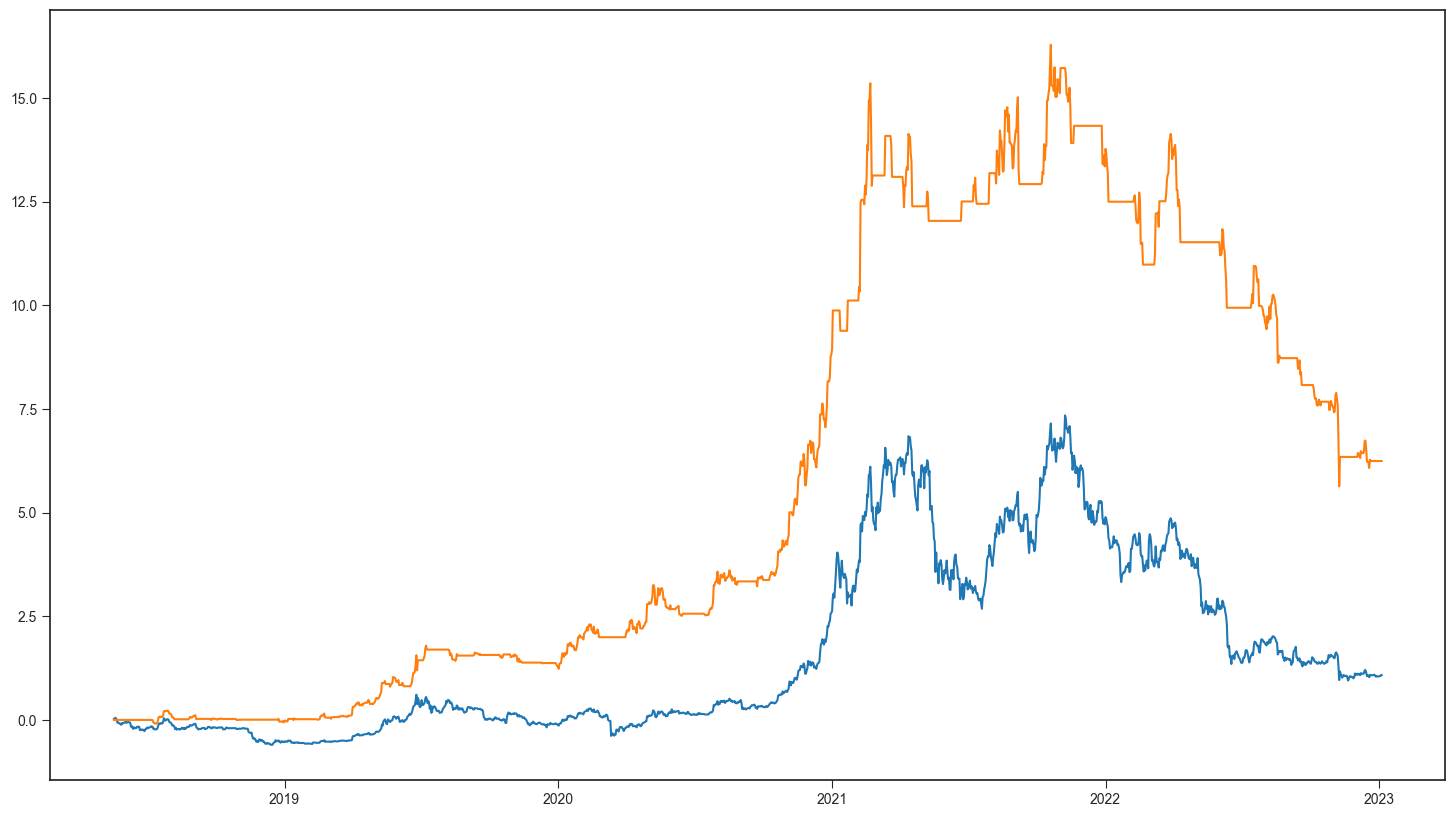

In [17]:
# Plot Equity Curves
fig = plt.figure(figsize=(18, 10))
plt.plot(df_main['bench_prod_exp'])
plt.plot(df_main['strat_prod_exp'])
plt.show()

### Save Data

In [18]:
# Save Data
# df_main.to_csv('data/HMM-SPY.csv')

In [19]:
print(X_test.values[-1])

[0.00684411 0.01648512]
